Similar analysis as bmw_MT but for mean deviation (straightness) of reaching trajectory

In [1]:
import os
import sys
from pathlib import Path
import glob
import getpass
import importlib

import numpy as np
import pandas as pd
import scipy.io as sio
from statsmodels.stats.anova import AnovaRM
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist')
fMRI_behavDir = os.path.join(baseDir,'data','fMRI','behavioural')
train_behavDir = os.path.join(baseDir,'data','training')
anaDir = os.path.join(baseDir,'analysis')
figDir = os.path.join(baseDir,'figures')

path = {'baseDir': baseDir,
        'fMRI_behavDir': fMRI_behavDir,
        'train_behavDir': train_behavDir,
        'anaDir': anaDir}



## Unimanual MD

/var/folders/nr/t5g2tr2x3rz2wtwsv95fhttm0000gn/T/ipykernel_15050/1823425340.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uni['MD'] = MD


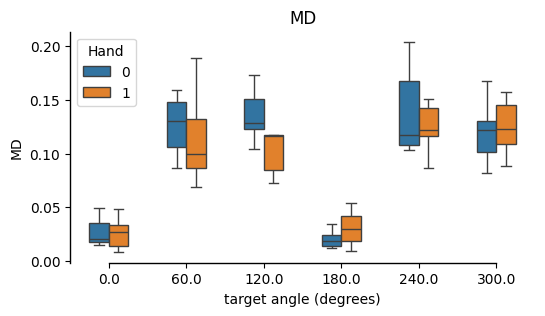

                      F Value  Num DF  Den DF    Pr > F
targetAngle_L       32.531017     5.0    30.0  2.98e-11
Hand                 2.249378     1.0     6.0  1.84e-01
targetAngle_L:Hand   2.301321     5.0    30.0  6.96e-02


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,targetAngle_L,0.0,60.0,True,True,-5.665657,6.0,two-sided,0.001300,0.019504,bonf,33.24,-3.421971
1,targetAngle_L,0.0,120.0,True,True,-8.259789,6.0,two-sided,0.000170,0.002555,bonf,169.794,-4.966872
2,targetAngle_L,0.0,180.0,True,True,-0.494744,6.0,two-sided,0.638373,1.000000,bonf,0.391,-0.066734
3,targetAngle_L,0.0,240.0,True,True,-6.791178,6.0,two-sided,0.000499,0.007483,bonf,71.416,-3.903519
4,targetAngle_L,0.0,300.0,True,True,-7.777591,6.0,two-sided,0.000238,0.003568,bonf,129.63,-4.387319
5,targetAngle_L,60.0,120.0,True,True,-0.200367,6.0,two-sided,0.847813,1.000000,bonf,0.359,-0.083986
6,targetAngle_L,60.0,180.0,True,True,5.327310,6.0,two-sided,0.001783,0.026741,bonf,25.882,3.303524
7,targetAngle_L,60.0,240.0,True,True,-0.947326,6.0,two-sided,0.380047,1.000000,bonf,0.503,-0.409689
8,targetAngle_L,60.0,300.0,True,True,-0.322686,6.0,two-sided,0.757882,1.000000,bonf,0.369,-0.071747
9,targetAngle_L,120.0,180.0,True,True,8.155434,6.0,two-sided,0.000183,0.002742,bonf,160.337,4.688185


In [ ]:
ana = pd.read_csv(os.path.join(anaDir, 'bmw.csv'))
df_uni = ana[ana.Uni_or_Bi == 0]
idx_left = df_uni.Hand == 0
idx_right = df_uni.Hand == 1
MD = df_uni.MD_left.values
MD[idx_right] = df_uni.MD_right[idx_right]
df_uni['MD'] = MD

fig, ax = plt.subplots(figsize=(6, 3))
sns.boxplot(data=df_uni, x="targetAngle_L", y='MD', hue="Hand", width=0.5, fliersize=0)
plt.xlabel('target angle (degrees)')
plt.title(f'MD')
# plt.ylim((0,1000))
utils.please.make_it_pretty(ax=ax)
# plt.savefig(os.path.join(figDir, 'behaviour', f'unimanual_MT.pdf'), bbox_inches="tight")
plt.show()

# ANOVA RM:
table = AnovaRM(data=df_uni, depvar='MD', subject='sn', within=['targetAngle_L', 'Hand'])
results = table.fit()
anova_df = results.anova_table.copy()
anova_df['Pr > F'] = anova_df['Pr > F'].apply(lambda p: f"{p:.2e}")
print(anova_df)

# pairwise t-tests:
pg.pairwise_tests(data=df_uni, dv='MD', within=['targetAngle_L'], subject='sn', padjust='bonf', interaction=True, alpha=0.05)



## Bimanual 

<Axes: xlabel='direction', ylabel='MD'>

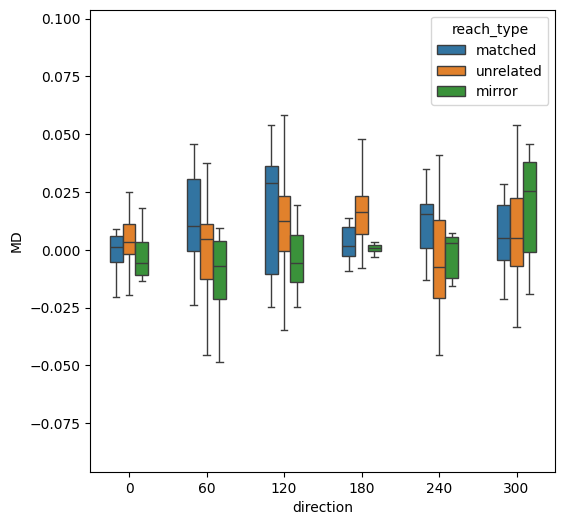

In [ ]:
ana = pd.read_csv(os.path.join(anaDir, 'bmw.csv'))
ana.loc[ana.reach_type=='mirror-diagonal', 'reach_type'] = 'unrelated'
directions = [0, 60, 120, 180, 240, 300]

df = {'sn': [], 'hand': [], 'direction': [], 'reach_type': [], 'MD': []}
for d1 in directions:
    left_uni = ana[(ana.Uni_or_Bi == 0) & (ana.Hand == 0) & (ana.targetAngle_L == d1)].MD_left.values.flatten()
    right_uni = ana[(ana.Uni_or_Bi == 0) & (ana.Hand == 1) & (ana.targetAngle_L == d1)].MD_right.values.flatten()

    for d2 in directions:
        bi_left = ana[ana.cond_name == f'bimanual_{d1}_{d2}']
        bi_right = ana[ana.cond_name == f'bimanual_{d2}_{d1}']

        MD_left = ana[ana.cond_name == f'bimanual_{d1}_{d2}'].MD_left.values.flatten() - left_uni
        MD_right = ana[ana.cond_name == f'bimanual_{d2}_{d1}'].MD_right.values.flatten() - right_uni

        df['sn'].extend(bi_left.sn.values.flatten().tolist() + bi_right.sn.values.flatten().tolist())
        df['hand'].extend([0] * len(MD_left) + [1] * len(MD_right))
        df['direction'].extend([d1] * len(MD_left) + [d1] * len(MD_right))
        df['reach_type'].extend([bi_left.reach_type.values.flatten()[0]] * len(MD_left) + [bi_right.reach_type.values.flatten()[0]] * len(MD_right))
        df['MD'].extend(MD_left.tolist() + MD_right.tolist())

df = pd.DataFrame(df)

df = df[df.hand==0]
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=df, x="direction", y='MD', hue="reach_type", width=0.5, fliersize=0, ax=ax)
plt.xlabel('direction')
plt.ylabel('MD minus unimanual')
plt.title(f'MD minus unimanual')
utils.please.make_it_pretty(ax=ax)
# plt.savefig(os.path.join(figDir, 'behaviour', f'unimanual_MT.pdf'), bbox_inches="tight")
plt.show()


df = df[df.hand==1]
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=df, x="direction", y='MD', hue="reach_type", width=0.5, fliersize=0, ax=ax)
plt.xlabel('direction')
plt.ylabel('MD minus unimanual')
plt.title(f'right hand')
utils.please.make_it_pretty(ax=ax)
# plt.savefig(os.path.join(figDir, 'behaviour', f'unimanual_MT.pdf'), bbox_inches="tight")
plt.show()

